In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
classes = 10

In [3]:
## get model from asignment 2 and check for acc and other metrices


In [4]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=classes)

train_dataset = datasets.CIFAR10(root="./data", train=True, transform = t, target_transform=target_t, download=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, transform = t, target_transform=target_t, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [6]:
label_names = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog", 
"horse",
"ship",
"truck"]

## Visualizing the images in datatset

In [7]:
# make better visualizer
# add the label and image information in the same plot, not print

img = next(iter(test_loader))[0][1].permute(1,2,0)
label = next(iter(test_loader))[1][1]
def visual(img):
    img = img / 2 + 0.5
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

# visual(img)
# print(label_names[torch.argmax(label)])


In [26]:
class Network(nn.Module):
    """
    This is the CNN architecture to evaluate CIFAR-10 dataset
    """
    def __init__(self, name: str, normalization: str):
        super().__init__()
        
#         Input: (3, 32, 32)
        self.name = name
        self.normalization = normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         After Conv1 and maxpool: (6, 14, 14) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

#         After Conv2 and maxpool: (16, 5, 5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
        if self.normalization == "batch":
            self.conv2_bn = nn.BatchNorm2d(16)
            self.fc1_bn = nn.BatchNorm1d(120)
            self.fc2_bn = nn.BatchNorm1d(84)
        
        if self.normalization == "group":
            self.conv1_group = nn.GroupNorm(3, 6)
            self.conv2_group = nn.GroupNorm(4, 16)
            
        if self.normalization == "dropout":
            self.in_dropout = nn.Dropout(p=0.1)
            self.cnn_dropout = nn.Dropout(p=0.5)
            self.lin_dropout = nn.Dropout(p=0.5)
        
        
    def forward(self, x):
        if self.normalization == "dropout":
            x = self.in_dropout(x)
            
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv1(x))))
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv2(x))))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.lin_dropout(self.fc1(x)))
            x = F.relu(self.lin_dropout(self.fc2(x)))
            x = self.fc3(x)
            
        elif self.normalization == "batch":
            x = self.maxpool(F.relu(self.conv1(x)))
            x = self.maxpool(F.relu(self.conv2_bn(self.conv2(x))))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1_bn(self.fc1(x)))
            x = F.relu(self.fc2_bn(self.fc2(x)))
            x = self.fc3(x)
            
        elif self.normalization == "group":
            x = self.maxpool(F.relu(self.conv1_group(self.conv1(x))))
            x = self.maxpool(F.relu(self.conv2_group(self.conv2(x))))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        
        elif self.normalization == "no":
            x = self.maxpool(F.relu(self.conv1(x)))
            x = self.maxpool(F.relu(self.conv2(x)))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x
    

In [27]:
def train_epoch(model, train_loader, optimizer, criterion, epoch):
    loss_list = []
    running_loss = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, (data, target) in pbar:
        data, target = data.to(device), target.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss =+ loss.item()
        loss_list.append(loss.item())

        if idx % 5 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")
    avg_loss = np.mean(loss_list)
    return loss_list, avg_loss


def testing(model, test_loader, criterion):
    model.eval()
    total_corr = 0
    loss_list = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            
            loss = criterion(output, target)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
            loss_list.append(loss.item())
            
    accuracy = (total_corr/len(test_dataset))
    
    return accuracy, np.mean(loss_list)

def training(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
#     Training time per epoch calculate and display
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "valid_acc": [],
        "loss_iters":[]
    }
    
    for epoch in range(num_epochs):
        stats["epoch"].append(epoch + 1)
        # training 
        epoch_loss_list, epoch_loss = train_epoch(model, train_loader, optimizer, criterion, epoch)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
        
        # testing
        acc, v_loss = testing(model, test_loader, criterion)        
        stats["valid_acc"].append(acc.item())
        stats["val_loss"].append(v_loss)
        
        if (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            saving_model(model, optimizer, epoch, stats)
            print(f"Accuracy for epoch: {epoch+1} is ", stats["valid_acc"][-1])


In [28]:
# util functions 
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats


In [29]:
def training_full_model(name: str, normalization: str, train_loader, valid_loader, num_epochs):
    
    model = Network(name, normalization).to(device)
    summary(model.to(device), (3,32,32))
    LR = 3e-4
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs)

## Training models


In [12]:
training_full_model(name="model_with_dropout", normalization="dropout", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             456
           Dropout-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
           Dropout-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Linear-8                  [-1, 120]          48,120
           Dropout-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Dropout-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
---------------------------------

Epoch 3, Itr 96, Loss 1.86323: 100%|████████████| 98/98 [00:07<00:00, 12.39it/s]


Accuracy for epoch: 3 is  0.3685999810695648


Epoch 6, Itr 96, Loss 1.61657: 100%|████████████| 98/98 [00:07<00:00, 12.53it/s]


Accuracy for epoch: 6 is  0.4316999912261963


Epoch 9, Itr 96, Loss 1.68306: 100%|████████████| 98/98 [00:07<00:00, 12.80it/s]


Accuracy for epoch: 9 is  0.44189998507499695


Epoch 12, Itr 96, Loss 1.59687: 100%|███████████| 98/98 [00:07<00:00, 12.93it/s]


Accuracy for epoch: 12 is  0.445499986410141


Epoch 15, Itr 96, Loss 1.62262: 100%|███████████| 98/98 [00:07<00:00, 12.87it/s]


Accuracy for epoch: 15 is  0.44669997692108154


Epoch 18, Itr 96, Loss 1.62590: 100%|███████████| 98/98 [00:07<00:00, 12.88it/s]


Accuracy for epoch: 18 is  0.44679999351501465


In [13]:
training_full_model(name="model_without_dropout", normalization="no", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Epoch 3, Itr 96, Loss 1.64379: 100%|████████████| 98/98 [00:07<00:00, 12.92it/s]


Accuracy for epoch: 3 is  0.42649999260902405


Epoch 6, Itr 96, Loss 1.47853: 100%|████████████| 98/98 [00:07<00:00, 13.00it/s]


Accuracy for epoch: 6 is  0.486299991607666


Epoch 9, Itr 96, Loss 1.48262: 100%|████████████| 98/98 [00:07<00:00, 12.80it/s]


Accuracy for epoch: 9 is  0.4998999834060669


Epoch 12, Itr 96, Loss 1.35359: 100%|███████████| 98/98 [00:07<00:00, 12.90it/s]


Accuracy for epoch: 12 is  0.49869999289512634


Epoch 15, Itr 96, Loss 1.35167: 100%|███████████| 98/98 [00:07<00:00, 12.66it/s]


Accuracy for epoch: 15 is  0.5059999823570251


Epoch 18, Itr 96, Loss 1.34410: 100%|███████████| 98/98 [00:07<00:00, 12.72it/s]


Accuracy for epoch: 18 is  0.5072000026702881


In [15]:
training_full_model(name="model_with_batch", normalization="batch", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
       BatchNorm2d-4           [-1, 16, 10, 10]              32
         MaxPool2d-5             [-1, 16, 5, 5]               0
            Linear-6                  [-1, 120]          48,120
       BatchNorm1d-7                  [-1, 120]             240
            Linear-8                   [-1, 84]          10,164
       BatchNorm1d-9                   [-1, 84]             168
           Linear-10                   [-1, 10]             850
Total params: 62,446
Trainable params: 62,446
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.24
Estimated Tot

Epoch 3, Itr 96, Loss 1.31906: 100%|████████████| 98/98 [00:07<00:00, 12.75it/s]


Accuracy for epoch: 3 is  0.5238999724388123


Epoch 6, Itr 96, Loss 1.08224: 100%|████████████| 98/98 [00:07<00:00, 12.59it/s]


Accuracy for epoch: 6 is  0.5770999789237976


Epoch 9, Itr 96, Loss 1.00732: 100%|████████████| 98/98 [00:07<00:00, 12.64it/s]


Accuracy for epoch: 9 is  0.5974999666213989


Epoch 12, Itr 96, Loss 0.98357: 100%|███████████| 98/98 [00:07<00:00, 12.63it/s]


Accuracy for epoch: 12 is  0.5986999869346619


Epoch 15, Itr 96, Loss 1.00705: 100%|███████████| 98/98 [00:07<00:00, 12.75it/s]


Accuracy for epoch: 15 is  0.6003000140190125


Epoch 18, Itr 96, Loss 0.93751: 100%|███████████| 98/98 [00:07<00:00, 12.91it/s]


Accuracy for epoch: 18 is  0.6003999710083008


In [30]:
training_full_model(name="model_with_group", normalization="group", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         GroupNorm-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
         GroupNorm-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,050
Trainable params: 62,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
---------------------------------------------

Epoch 3, Itr 96, Loss 1.49709: 100%|████████████| 98/98 [00:07<00:00, 12.62it/s]


Accuracy for epoch: 3 is  0.4684999883174896


Epoch 6, Itr 96, Loss 1.33957: 100%|████████████| 98/98 [00:07<00:00, 12.59it/s]


Accuracy for epoch: 6 is  0.5117999911308289


Epoch 9, Itr 96, Loss 1.31702: 100%|████████████| 98/98 [00:07<00:00, 12.81it/s]


Accuracy for epoch: 9 is  0.5307999849319458


Epoch 12, Itr 96, Loss 1.34717: 100%|███████████| 98/98 [00:07<00:00, 12.86it/s]


Accuracy for epoch: 12 is  0.5327999591827393


Epoch 15, Itr 96, Loss 1.19206: 100%|███████████| 98/98 [00:07<00:00, 12.81it/s]


Accuracy for epoch: 15 is  0.5358999967575073


Epoch 18, Itr 96, Loss 1.23203: 100%|███████████| 98/98 [00:07<00:00, 12.64it/s]


Accuracy for epoch: 18 is  0.5357999801635742


### Loading a model from disk


In [31]:
best_dropout = Network(name="best_dropout", normalization="dropout")
best_batch = Network(name="best_batch", normalization="batch")
best_group = Network(name="best_group", normalization="group")
best_no_dropout = Network(name="best_no_dropout", normalization="no")

best_dropout, _, _, stats_d = loading_model(best_dropout, "models/model_with_dropout_18.pth")
best_no_dropout, _, _, stats_no_d = loading_model(best_no_dropout, "models/model_without_dropout_18.pth")
best_batch, _, _, stats_batch = loading_model(best_batch, "models/model_with_batch_18.pth")
best_group, _, _, stats_group = loading_model(best_group, "models/model_with_group_18.pth")

### Training loss plots 

In the figure below is the training loss for model with and without dropout. 

**there has to be something wrong here since model with dropout is overfitting more lol**


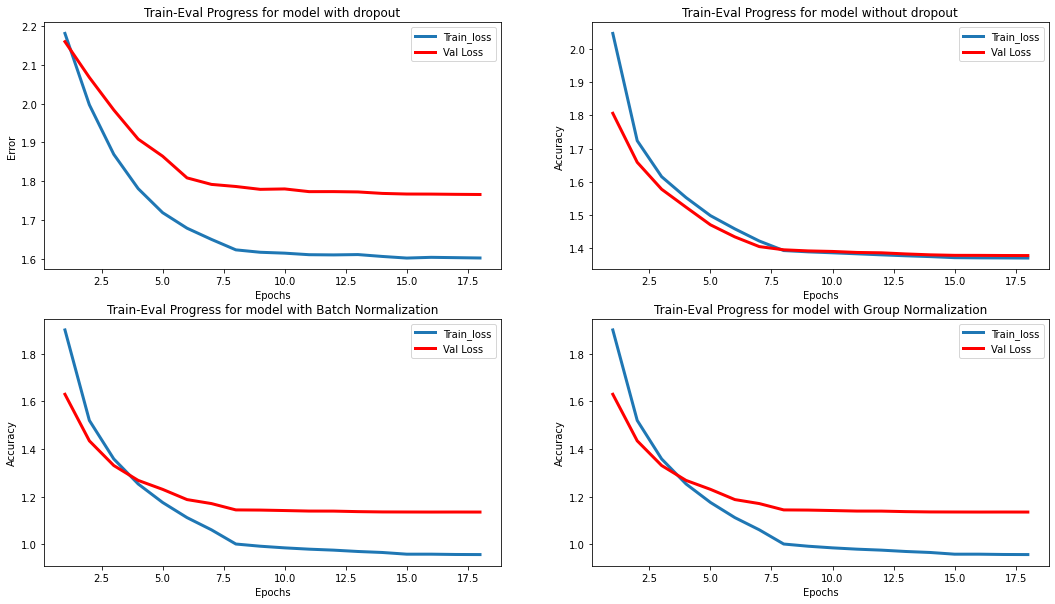

In [34]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 10)

ax[0][0].plot(stats_d['epoch'], stats_d['train_loss'], label="Train_loss", linewidth=3)
ax[0][0].plot(stats_d['epoch'], stats_d['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Error")
    
ax[0][0].set_title("Train-Eval Progress for model with dropout")

ax[0][1].plot(stats_no_d['epoch'], stats_no_d['train_loss'], label="Train_loss", linewidth=3)
ax[0][1].plot(stats_no_d['epoch'], stats_no_d['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Accuracy")
    
ax[0][1].set_title("Train-Eval Progress for model without dropout")

ax[1][0].plot(stats_batch['epoch'], stats_batch['train_loss'], label="Train_loss", linewidth=3)
ax[1][0].plot(stats_batch['epoch'], stats_batch['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Accuracy")
    
ax[1][0].set_title("Train-Eval Progress for model with Batch Normalization")


ax[1][1].plot(stats_batch['epoch'], stats_batch['train_loss'], label="Train_loss", linewidth=3)
ax[1][1].plot(stats_batch['epoch'], stats_batch['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Accuracy")
    
ax[1][1].set_title("Train-Eval Progress for model with Group Normalization")

plt.show()

### Accuracy for different models

Now is the accuracy for different models. 

**I mean it makes sense that the model without dropout will have more acc for same number of spochs. But it should not be this less**

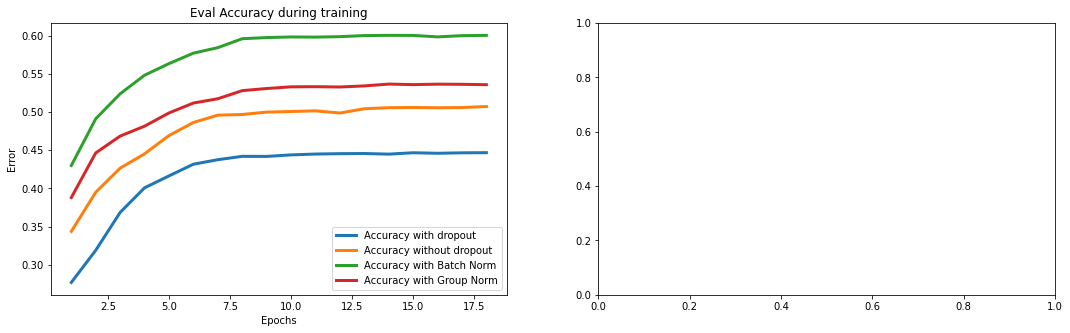

In [36]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(stats_d['epoch'], stats_d['valid_acc'], label="Accuracy with dropout", linewidth=3)
ax[0].plot(stats_no_d['epoch'], stats_no_d['valid_acc'], label="Accuracy without dropout", linewidth=3)
ax[0].plot(stats_batch['epoch'], stats_batch['valid_acc'], label="Accuracy with Batch Norm", linewidth=3)
ax[0].plot(stats_group['epoch'], stats_group['valid_acc'], label="Accuracy with Group Norm", linewidth=3)

ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
    
ax[0].set_title("Eval Accuracy during training")

plt.show()

### Visualizing the kernels

Here we are visualizing the kernels

In [37]:
# keys = list(best_no_dropout.state_dict().keys())
# def vis_kernel(kernels):
#     n,c,w,h = kernels.shape
#     fig, ax = plt.subplots(1,6)
    
#     for idx, i in enumerate(kernels):
        
#         img = i.squeeze().permute(1,2,0).numpy()
#         ax[idx].imshow(img)

In [38]:
# vis_kernel(best_no_dropout.state_dict()[keys[0]])

In [39]:
#Function for plottinng kernels and activation maps
def plot(tensor, plot_kernels, n_cols=10):
    n_kernels = tensor.shape[0]
    n_rows = 1+ n_kernels // n_cols
    fig = plt.figure(figsize=(n_cols,n_rows))
    for i in range(n_kernels):
        ax1 = fig.add_subplot(n_rows,n_cols,i+1)
        if plot_kernels==True:
            ax1.imshow(tensor[i][0,:,:].cpu(),cmap='gray')
        else:
            ax1.imshow(tensor[i],cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

Kernel Visualization
torch.Size([6, 3, 5, 5])


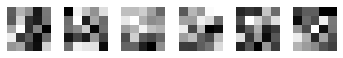

torch.Size([16, 6, 5, 5])


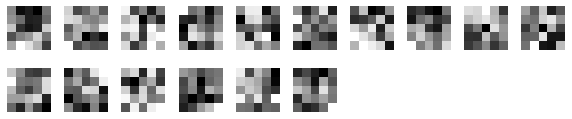

In [40]:
print("Kernel Visualization")
filters = best_no_dropout.modules()
model_layers = [i for i in best_no_dropout.children()]
first_layer = model_layers[0]
second_layer = model_layers[2]

first_kernels = first_layer.weight.data.clone()
print(first_kernels.shape)
plot(first_kernels,True)


second_kernels = second_layer.weight.data.clone()
print(second_kernels.shape)
plot(second_kernels,True)

This shows the kernel visualization. Our kernels are of sizes 5 x 5, hence we can see a grid of the same size. The dark boxes indicate that the weights are of lower magnitude and the light ones indicate the weights are of greater magnitude. As the patches go from dark to light, the weight values keep increasing.



## Visualization of Activations 

Activation Visualization
Convolutional Output Layer - 1


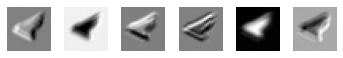

After first convolution and maxpool layer torch.Size([6, 14, 14])
Convolutional Output Layer - 2


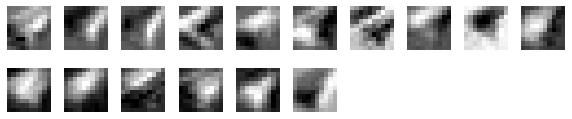

After second convolution and maxpool layer torch.Size([16, 5, 5])


In [41]:
print("Activation Visualization")   
img, label = test_dataset[21]
img_input = img.unsqueeze(0)

result1 = best_no_dropout.conv1(img_input)
result1 = result1.squeeze()

print('Convolutional Output Layer - 1')
plot(result1.data.numpy(),False)
      
result1 = best_no_dropout.maxpool(result1)
print("After first convolution and maxpool layer",result1.shape)           


result1 = (result1.view(-1, 6*14*14))
resized_img = result1[0].view(1, 6, 14, 14)

result2 = best_no_dropout.conv2(resized_img)
result2 = result2.squeeze()
      
print('Convolutional Output Layer - 2')
plot(result2.data.cpu().numpy(),False)
result2 = best_no_dropout.maxpool(result2)
print("After second convolution and maxpool layer",result2.shape)   

These are our activation maps after the first and second convolution layers. After the first convolution layer, the activation maps highlight the image involved by either darkening/lightning the image. It is difficult to understand what the second layer is trying to achieve.